**Packages**

In [1]:
using Distributions
using OrdinaryDiffEq
using Turing
using LinearAlgebra
using QuadGK
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames
using CategoricalArrays

**Environment variables**

In [2]:
figures_dir = "figures/"
results_dir = "results/"
ENV["COLUMNS"] = 500;

**Utility functions**

In [3]:
function onehot!(df::DataFrame, col::Union{Symbol,String})
    cats = unique(df[!, col])
    col_names = string.(col, "_", cats)
    col_names = replace.(col_names, " " => "_")
    transform!(df, col => (x -> Float64.(x .== permutedims(cats))) => col_names)
    select!(df, Not(col))
end

function onehot!(df::DataFrame, cols::Vector)
    for col in cols
        onehot!(df, col)
    end
    df
end

onehot(df::DataFrame, col) = onehot!(copy(df), col)

onehot (generic function with 1 method)

## Research question

In the example, we want to estimate the average death rate of hospitalized patients grouping by sex, and use viral dynamics (ODE) to assess if existing Chronic Pulmonary Disease increases the risk of death.

## Data (provided by AHS)

Load and process data from patients admitted to hospitals. In this example we are only usng time of discharge, death flag, sex, and chronic pulmonary disease.

In [4]:
struct RiskCov19Data
    df::DataFrame
    timecol::Symbol
    deadcol::Symbol
    covarcols::Vector{Symbol}
    odegrcols::Vector{Symbol}
end

data_filename = pwd()*"/../../data/AHS/Restricted/analysis.csv"
data, header = readdlm(data_filename, ',', header=true)
df = DataFrame(data, vec(header))
df = df[1:500, :] # only taking a portion of the data for testing purposes
# handeling data types
df = identity.(df) # auto identify the data type
features = ["Disch_days", "Dead", 
            "Sex", "Chronic Pulmonary Disease"]
select!(df, features)
# Remove missing
deleteat!(df, df.Sex.=="")
# Transform
rename!(df, replace.(names(df), " " => "_"))
rename!(df, replace.(names(df), "." => ""))
transform!(df, :Disch_days => ByRow(x -> Float64(-x)) => :Time,
               :Dead => ByRow(x -> x == "True" ? 1.0 : 0.0) => :Dead,
               :Sex => ByRow(x -> x == "Male" ? 1.0 : 0.0) => :Male,
               :Chronic_Pulmonary_Disease => ByRow(x -> x == "True" ? 1 : 2);
               renamecols=false)
select!(df, Not([:Disch_days, :Sex]))
# data type
data = RiskCov19Data(df, :Time, :Dead, [:Male], [:Chronic_Pulmonary_Disease])
# display
display(first(data.df, 6))
display(describe(data.df))
println("Dimensions: ", size(data.df))

,Dead,Chronic_Pulmonary_Disease,Time,Male
,Float64,Int64,Float64,Float64
1,0.0,2,5.0,0.0
2,0.0,2,16.0,0.0
3,0.0,2,25.0,1.0
4,0.0,1,27.0,1.0
5,0.0,2,12.0,0.0
6,1.0,2,10.0,0.0


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Dead,0.2,0.0,0.0,1.0,0,Float64
2,Chronic_Pulmonary_Disease,1.854,1,2.0,2,0,Int64
3,Time,18.418,0.0,13.0,201.0,0,Float64
4,Male,0.512,0.0,1.0,1.0,0,Float64


Dimensions: (500, 4)


## ODE model

This model includes the fraction of healthy cells in the lung epithilium $E$ which are infected by free virons $V$.

$$
\begin{aligned}
    \frac{d E}{dt} & = \mu_E E(1-E) - \delta_E E \frac{V}{V_{max}},\\
\end{aligned}
$$ 

where

$$
\begin{aligned}
V(t) & = v_1(t)v_2(t)v_3(t),\\
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

and $H(t)$ denotes the Heaviside function (smoothed for numerical stability). Here, $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. At time $t=0$, moment of infection, we assume full proportion of healthy cells.

Currently we are estimating $\mu_E$ and $\delta_E$, and fixing the rest of the parameters.

**To do**: estimate on use random values for the parameters of $V(t)$. I think fixed values are unrealistic.

In [5]:
struct RiskCov19ODEVars
    names::Vector{Symbol}
    description::Vector{String}
    ICs::Vector{AbstractFloat}
    covars_ix::Vector{Integer}
end

struct RiskCov19ODEPars
    names::Vector{Symbol}
    values::Vector{AbstractFloat}
end

struct RiskCov19ODEModel
    id::String
    name::String
    prob::ODEProblem
    vars::RiskCov19ODEVars
    pars::RiskCov19ODEPars
end

In [ ]:
## Virus load function
function VLF(t::Float64, p::Vector)
    a₁, a₂, b₁, b₂, α, Vmax, Vmin = p
    H = 0.5*(tanh(1e3*(t - a₂)) + 1.)
    v₁ = 1.0 + (Vmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
    v₂ = 1.0 - H + H*exp(-α*(t - a₂))
    v₃ = 1.0 - (1.0 - Vmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
    v₁*v₂*v₃
end

## Model: VLF001
## VLF + Lung tissue
# ODE model
function modelODE!(du, u, p, t)
    E, = u
    a₁ = 0.5     # a₁
    a₂ = 4.0     # a₂
    b₁ = 13.0    # b₁
    b₂ = 19.0    # b₂
    α = 0.1     # α
    Vmin = 1e-8    # Vmin
    Vmax = 3.7e3   # Vmax
    μ_E, δ_E = p
    V(t) = VLF(t, [a₁, a₂, b₁, b₂, α, Vmax, Vmin])
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*V(t)/Vmax # Healthy lung epithelium
end
u0 = [
    1.0   #E: Healthy lung epithilium
]
vars = RiskCov19ODEVars([:E, ], ["Healthy lung cells"], u0, [1, ])
tspan = (0.0, 40.0)
pars = RiskCov19ODEPars([:μ_E, :δ_E], [0.01, 0.15])
prob = ODEProblem(modelODE!, u0, tspan, pars.values)
model_VLF001 = RiskCov19ODEModel("VLF001", "VLF + Lung tissue", prob, vars, pars)

Solution of the ODE using and initial guess.

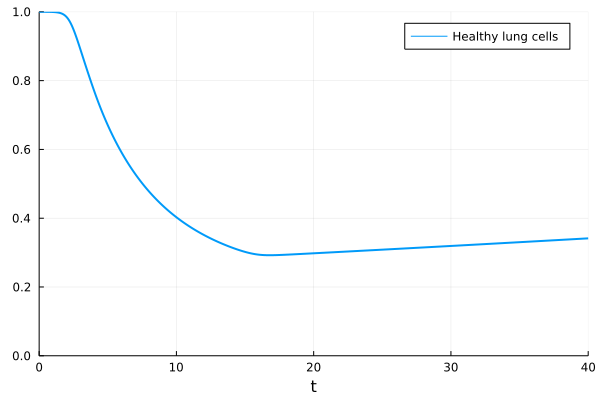

In [6]:
sol = solve(model_VLF001.prob, Tsit5(), dtmax=1e-1)
plot(sol, labels=vars.description[1], lw=2, ylims=(0., 1))

## Survival model

The survival model is given by the hazard function

$$ h(t) = \lambda \exp(x^T\beta+y(t)^T\gamma), $$

where $\lambda$ is the basal hazard rate, $x$ is the design matrix for the linear covariates, $\beta$ is the vector linear covariate coefficients, $y(t)=1-E(t)$ is the solution of the ODE, and $\gamma$ is the vector of the ODE covariates cofficients.

$$p(t)=h(t)\exp(-\int_0^t h(s)ds)$$

In [7]:
function rename_pars(chn, model, data)
    num_ode_groups = length(unique(Matrix(df[:, data.odegrcols])))
    names = String.(chn.name_map.parameters)
    filter!(x->occursin("priors", x), names)
    d = Dict{Symbol, Symbol}()
    for (i, name) in enumerate(String.(model.pars.names))
        for k = 1:num_ode_groups
            push!(d, Symbol("priors[$i][$k]") => Symbol("$name[$k]") )
        end
    end
    return replacenames(chn, d)
end

rename_pars (generic function with 1 method)

In [8]:
@model function modelProb(data::RiskCov19Data, ODEModel::RiskCov19ODEModel, ::Type{T} = Float64) where {T}
    # data: RiskCov19 structure containing (df, timecol, deadcol, covarcols, odegrcols)
    # ODEModel: RiskCov19 structure containing (id, name, prob, vars, pars)
    
    ## Info contained in data
    df = data.df
    N = size(df, 1) 
    t = df[:, data.timecol]
    d = df[:, data.deadcol]
    X = Matrix(df[:, data.covarcols])
    num_lin_covars = length(data.covarcols)
    Y = Matrix(df[:, data.odegrcols])
    num_ode_groups = length(unique(Y))
            
    ## Info contained in ODEModel
    pars = ODEModel.pars
    vars = ODEModel.vars
    num_ode_covar = length(vars.covars_ix)
    num_rand_vars = length(pars.values) 

    ## Linear covariates
    μ_β = fill(0., num_lin_covars)
    Σ_β = 1 ./ std(X, dims=1)[:]
    β ~ MvNormal(μ_β, Σ_β)
    z = X*β
    
    ## ODE covariates
    # priors[i][k] is the value of the i-th parameter in the ODE of group k
    priors = Vector(undef, num_rand_vars)
    for i = 1:num_rand_vars
       priors[i] ~ filldist(truncated(Normal(pars.values[i], 0.01), 0.0, Inf), num_ode_groups)
    end
    η = Vector(undef, num_ode_groups)
    # sol[k] is the solution of the ODE for the k-th group
    sol = Vector(undef, num_ode_groups)
    # TODO: resolve t_s
    t_s = 5.0
    for k = 1:num_ode_groups
        η[k] = [priors[i][k] for i = 1:num_rand_vars]
        prob = remake(ODEModel.prob, p=η[k], tspan=(0.0, t_s + maximum(t)))
        sol[k] = solve(prob, Tsit5(), dt=0.1)
    end
    y(t, k) = sol[k](t)[vars.covars_ix]
    γ ~ filldist(Normal(0., 0.1), num_ode_covar)
    
    ## Survival model
    # Basal hazard rate
    λ ~ Exponential(1.0)
    if λ <= 0.0
        Turing.@addlogprob! -Inf
        return
    end
    # Exponential basal hazard function
    hazard₀(t, λ) = λ
    # hazard function
    hazard(t, z, k, λ) = hazard₀(t, λ)*exp(z + y(t, k)'*γ)
    
    # iterate for each patient
    for i in 1:N
        # cumulative hazard function
        h = hazard(t_s + t[i], z[i], Y[i], λ)
        H = try
            quadgk(s -> hazard(s, z[i], Y[i], λ), 0., t_s + t[i])[1]
        catch e
            Turing.@addlogprob! -Inf
            return
        end
        # TODO: add exception to unbounded integral
        # user Log-likelihood
        Turing.@addlogprob! d[i]*log(h) - H
    end
end

modelProb (generic function with 3 methods)

In [9]:
## Simulation
n_samples = 1_000
n_chains = 2
sampler = NUTS()
model = modelProb(data, model_VLF001)
tstat = @timed chns = mapreduce(c -> sample(model, sampler, n_samples), chainscat, 1:n_chains)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/Ir2iS/src/inference/hmc.jl:188
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/shigoto/.julia/packages/SciMLBase/jj8Ix/src/integrator_interface.jl:331
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
Sampling:  30%|████████████▎                            |  ETA: 0:30:23┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/shigoto/.julia/packages/SciMLBase/jj8Ix/src/integrator_interface.jl:331
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0

(value = MCMC chain (1000×19×2 Array{Float64, 3}), time = 4198.716537497, bytes = 6392042915372, gctime = 979.161528085, gcstats = Base.GC_Diff(6392042915372, 34143, 87, 94826538157, 11246989, 12, 979161528085, 49175, 9))

Chains MCMC chain (1000×19×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 4178.17 seconds
Compute duration  = 4175.48 seconds
parameters        = β[1], μ_E[1], μ_E[2], δ_E[1], δ_E[2], γ[1], λ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

        β[1]    0.2215    0.2078     0.0046    0.0066   1140.1646    1.0019        0.2731
      μ_E[1]    0.0123    0.0076     0.0002    0.0002   1387.4735    1.0016        0.3323
      μ_E[2]    0.0138    0.0081     0.0002    0.0002   1778.3765    0.9999        0.4259
      δ_E[1]    0.1504    0.0102     0.0002    0.0002   1

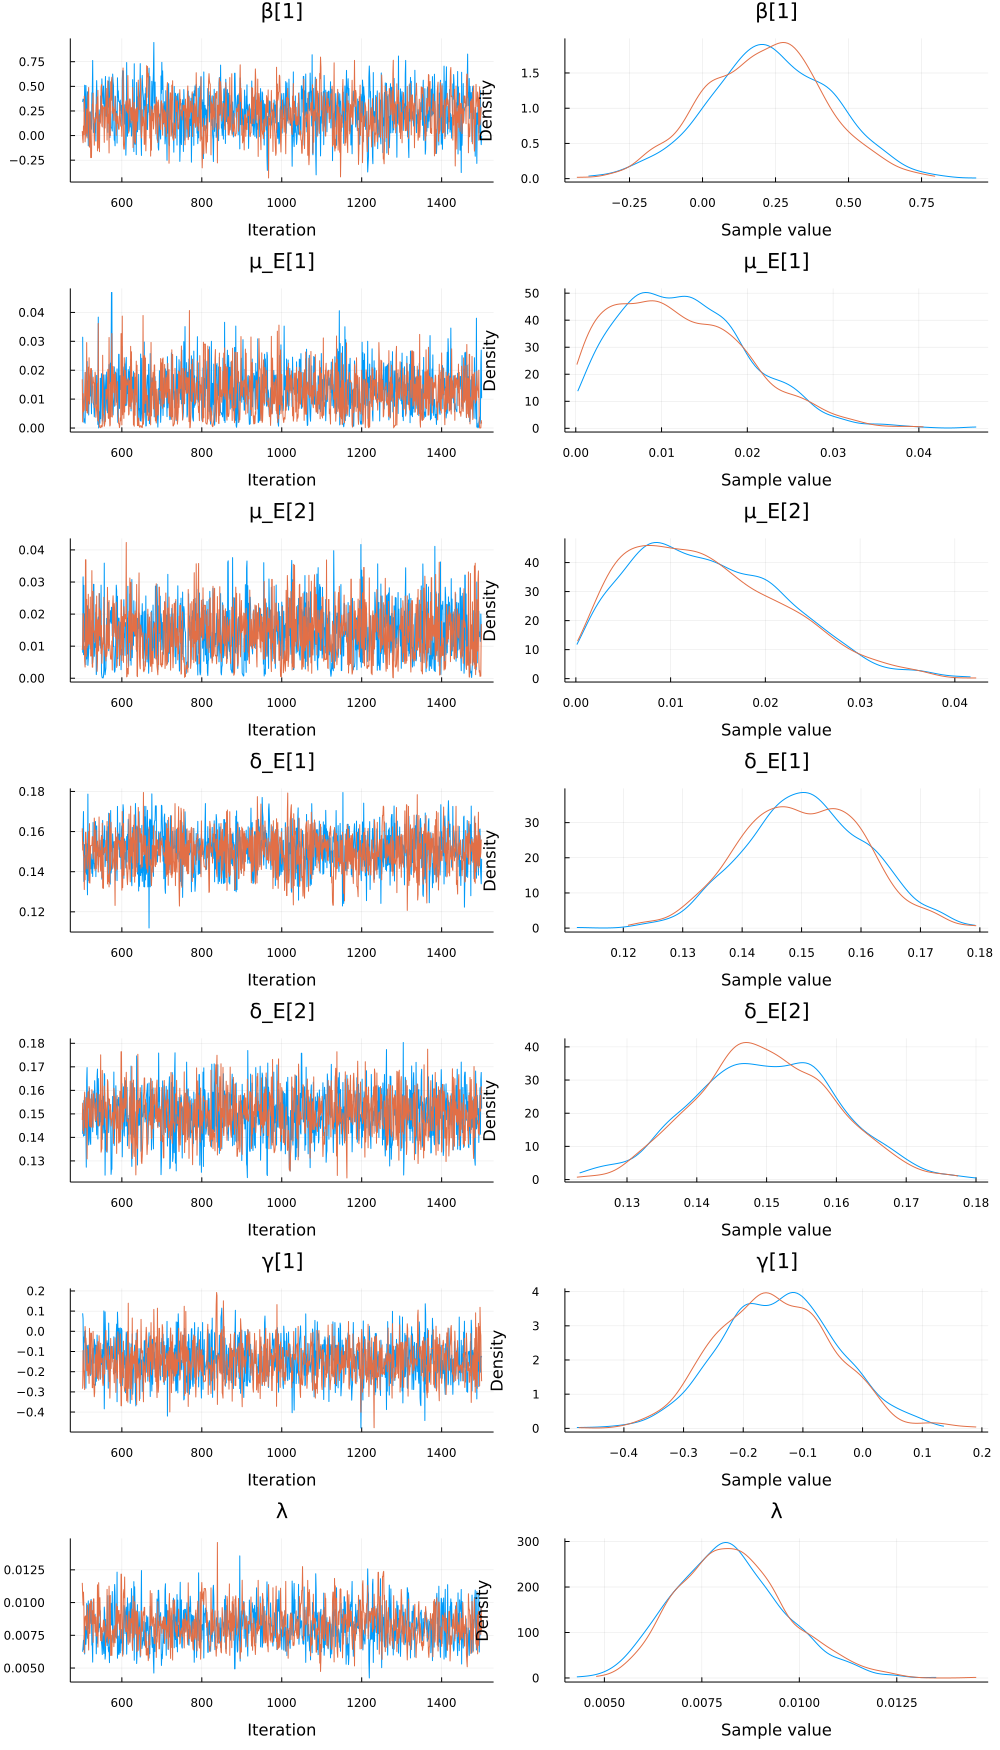

In [11]:
chns = rename_pars(chns, model_VLF001, data)
display(chns)
plot(chns)

In [12]:
[mean(chns, :λ)
 mean(chns, :λ)*exp(mean(chns, Symbol("β[1]")))]

2-element Vector{Float64}:
 0.008246237861622898
 0.010290760650761526

In [17]:
chns

Chains MCMC chain (1000×19×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 4178.17 seconds
Compute duration  = 4175.48 seconds
parameters        = β[1], μ_E[1], μ_E[2], δ_E[1], δ_E[2], γ[1], λ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

        β[1]    0.2215    0.2078     0.0046    0.0066   1140.1646    1.0019        0.2731
      μ_E[1]    0.0123    0.0076     0.0002    0.0002   1387.4735    1.0016        0.3323
      μ_E[2]    0.0138    0.0081     0.0002    0.0002   1778.3765    0.9999        0.4259
      δ_E[1]    0.1504    0.0102     0.0002    0.0002   1

In [3]:
1/0.0082

121.95121951219511

In [23]:
function solve_ODE_pred(chn, model, data)
    t = df[:, data.timecol]
    num_ode_groups = length(unique(Matrix(df[:, data.odegrcols])))
    par_names = string.(model.pars.names)
    t_s = 5.0
    sol = Vector{ODESolution}(undef, num_ode_groups)
    for i = 1:num_ode_groups
        p = [mean(chn, s) for s in Symbol.(par_names.*"[$i]")]
        prob = remake(model.prob, p=p, tspan=(0.0, t_s + maximum(t)))
        sol[i] = solve(prob, Tsit5(), dt=0.1)
    end
    return sol
end
sols = solve_ODE_pred(chns, model_VLF001, data)

function predict_RiskCov19(newdata, chn, model, data)
    
    ## Info contained in data
    df = newdata.df
    N = size(df, 1) 
    t = df[:, newdata.timecol]
    d = df[:, newdata.deadcol]
    X = Matrix(df[:, newdata.covarcols])
    Y = Matrix(df[:, newdata.odegrcols])
    num_ode_groups = length(unique(Matrix(df[:, data.odegrcols])))
    
    ## Info contained in ODEModel
    par_names = model.pars.names
    
    ## Estimated values
    λ = mean(chn, :λ)
    β = [mean(chn, s) for s in namesingroup(chn, :β)]
    γ = [mean(chn, s) for s in namesingroup(chn, :γ)]
    
    ## Linear covariates
    z = X*β
    
    ## Solve ODEs
    t_s = 5.0
    sol = Vector{ODESolution}(undef, num_ode_groups)
    for k = 1:num_ode_groups
        p = [mean(chn, s) for s in Symbol.(string.(par_names).*"[$k]")]
        prob = remake(model.prob, p=p, tspan=(0.0, t_s + maximum(t)))
        sol[k] = solve(prob, Tsit5(), dt=0.1)
    end
    y(t, k) = sol[k](t)[vars.covars_ix]
    
    ## Survival model
    # Exponential basal hazard function
    hazard₀(t, λ) = λ
    # hazard function
    hazard(t, z, k, λ) = hazard₀(t, λ)*exp(z + y(t, k)'*γ)
    
    ## Compute probability
    pred = Vector{Float64}(undef, N)
    for i = 1:N
        h = hazard(t_s + t[i], z[i], Y[i], λ)
        H = try
            quadgk(s -> hazard(s, z[i], Y[i], λ), 0., t_s + t[i])[1]
        catch e
            Inf
        end
        pred[i] = h*exp(-H)
    end
    return pred
end

predict_RiskCov19 (generic function with 1 method)

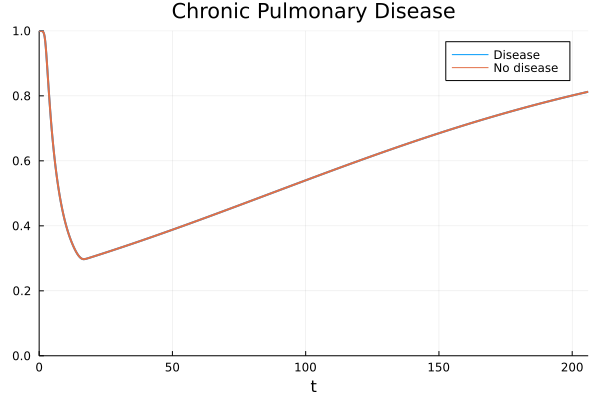

In [24]:
plot(sols[1], label="Disease", lw=2, ylims=(0., 1))
plot!(sols[1], label="No disease", lw=2)
title!("Chronic Pulmonary Disease")

In [34]:
insertcols!(data.df, 2, :Prediction => predict_RiskCov19(data, chns, model_VLF001, data))

,Dead,Prediction,Chronic_Pulmonary_Disease,Time,Male
,Float64,Float64,Int64,Float64,Float64
1,0.0,0.00721903,2,5.0,0.0
2,0.0,0.00671076,2,16.0,0.0
3,0.0,0.00733729,2,25.0,1.0
4,0.0,0.00719742,1,27.0,1.0
5,0.0,0.00693689,2,12.0,0.0
6,1.0,0.00703907,2,10.0,0.0
7,0.0,0.00892136,2,3.0,1.0
8,0.0,0.0082136,2,14.0,1.0
9,0.0,0.00592061,2,46.0,1.0


In [92]:
display("text/markdown", "**Computer Information:**")
vinfo = sprint(InteractiveUtils.versioninfo)
display("text/markdown",  "```$(vinfo)```")

using Pkg
display("text/markdown","**Packages Information:**")
pkgs = ["Turing", 
    "OrdinaryDiffEq", 
    "LinearAlgebra", 
    "QuadGK", 
    "LaTeXStrings", 
    "DelimitedFiles", 
    "DataFrames", 
    "CategoricalArrays"]
Pkg.status(pkgs)

**Computer Information:**

```Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: AMD Ryzen 7 4700U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, znver2)
```

**Packages Information:**

      Status `~/.julia/environments/v1.6/Project.toml`
  [324d7699] CategoricalArrays v0.10.2
  [a93c6f00] DataFrames v1.3.1
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v6.4.1
  [1fd47b50] QuadGK v2.4.2
  [fce5fe82] Turing v0.19.3
